## Import dependencies

In [1]:
# compute
import numpy as np
import numpy.matlib
import pandas as pd

# data io
import glob
import deepdish as dd
import sys
sys.path.append('../')

# image
import cv2

# stats
#import pycircstat as pyc
from scipy import stats

# plot
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from IPython.core.display import HTML 

# spykes
from neuropop import NeuroPop
from neurovis import NeuroVis

# local
import V4pyutils

## Read in files

### List files

In [2]:
h5path = '../V4pydata/H5data/M3/'
fname = glob.glob(h5path+'/*89a*')
fname
glob.glob(h5path+'/*89a*')

['../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev.h5_imagefeatures_wip',
 '../V4pydata/H5data/M3/Ro150212_289a_huecircle_0003_nev.h5',
 '../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev.h5',
 '../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev_imagefeatures_wip.h5']

### Natural

In [3]:
# Read using deepdish
nat_file = fname[2]
print nat_file
nat_dat = dd.io.load(nat_file)

../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev.h5


## Get features (X)

In [4]:
params = dict()
params['n_bins'] = 16 #number of bins of the histogram
params['window'] = [50, 300] #
params['radius'] = 200
params['n_patches'] = 16 #for natural stimuli
params['n_blocks'] = np.int(np.sqrt(params['n_patches']))
params['stimpath'] = '../V4pydata'

### natural features

#### non-visual

In [5]:
for_features_nat = nat_dat['eyes'][0].keys()

features_nat = dict()
for feat in for_features_nat:
    features_nat[feat] = np.array([nat_dat['eyes'][fix][feat] for fix in nat_dat['eyes']]) 

In [6]:
nat_df = pd.DataFrame(features_nat)
nat_df['badfix'] = nat_df['badfix']==1
nat_df['in_sac_blink'] = nat_df['in_sac_blink']==1
nat_df['out_sac_blink'] = nat_df['out_sac_blink']==1

nat_df['fix_duration'] = nat_df['fix_offset'] - nat_df['fix_onset']
nat_df['next_fix_duration'] = np.append(nat_df['fix_duration'][1:], 0)
nat_df['prev_fix_duration'] = np.append(0, nat_df['fix_duration'][0:-1])
nat_df['in_screen'] = np.all((nat_df['col']>=1, nat_df['col']<=1024, \
                                nat_df['row']>=1, nat_df['row']<=768), axis=0)
nat_df['row_drift'] = nat_df['fix_offset_row'] - nat_df['fix_onset_row']
nat_df['col_drift'] = nat_df['fix_offset_col'] - nat_df['fix_onset_col']
nat_df['drift'] = np.abs(nat_df['row_drift']) + np.abs(nat_df['col_drift'])

# sort columns
cols = nat_df.columns.tolist()
cols = ['trial', 'fixation', 'impath', 'imname', 'fix_onset', 'fix_offset', 'row', 'col',
        'fix_onset_row', 'fix_onset_col', 'fix_offset_row', 'fix_offset_col',
        'in_sac_blink', 'in_sac_dur', 'in_sac_pkvel',
        'out_sac_blink', 'out_sac_dur', 'out_sac_pkvel',
        'fix_duration','prev_fix_duration', 'next_fix_duration',
        'row_drift', 'col_drift', 'drift',
        'in_screen', 'badfix']

nat_df = nat_df[cols]

#### detect and label fixations for which patch will not intersect with the border

In [7]:
R = params['radius']
nat_df['in_screen_radius_200'] = (nat_df['row'] > R) & \
                                          (nat_df['row'] < (768 - R)) & \
                                          (nat_df['col'] > R) & \
                                          (nat_df['col'] < (1024 - R))

In [8]:
nat_df.head(5)

,trial,fixation,impath,imname,fix_onset,fix_offset,row,col,fix_onset_row,fix_onset_col,...,out_sac_pkvel,fix_duration,prev_fix_duration,next_fix_duration,row_drift,col_drift,drift,in_screen,badfix,in_screen_radius_200
0,1,1,stimuli/M3/Orig,0130.jpg,2.230,2.557,425.0,578.0,434.0,565.0,...,12.311564,0.327,0.000,0.183,-20.0,21.0,41.0,True,True,True
1,1,2,stimuli/M3/Orig,0130.jpg,2.596,2.779,499.0,597.0,489.0,594.0,...,141.512974,0.183,0.327,0.113,7.0,1.0,8.0,True,False,True
2,1,3,stimuli/M3/Orig,0130.jpg,2.832,2.945,678.0,310.0,676.0,311.0,...,126.929517,0.113,0.183,0.830,1.0,0.0,1.0,True,False,False
3,1,4,stimuli/M3/Orig,0130.jpg,2.996,3.826,460.0,82.0,469.0,108.0,...,129.210255,0.830,0.113,0.173,-8.0,-43.0,51.0,True,True,False
4,1,5,stimuli/M3/Orig,0130.jpg,3.883,4.056,174.0,234.0,180.0,226.0,...,224.264790,0.173,0.830,0.193,-8.0,11.0,19.0,True,False,False


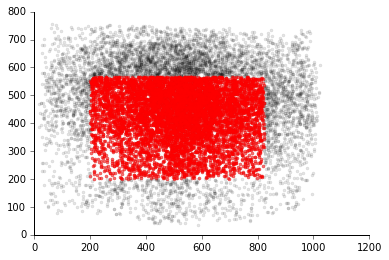

In [9]:
valid_fx = nat_df['in_screen_radius_%s' % params['radius']]
plt.plot(nat_df['col'], nat_df['row'], 'k.', alpha=0.1)
plt.plot(nat_df['col'][valid_fx], nat_df['row'][valid_fx], 'r.', alpha=0.5)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
plt.show()

## Get spike counts (Y)

### natural

In [10]:
params['selected_neuron'] = '0900'

spiketimes = nat_dat['spikes'][params['selected_neuron']]
neuron = NeuroVis(spiketimes, name=params['selected_neuron'])
nat_df['Y_%s' % params['selected_neuron']] = neuron.get_spikecounts(nat_df['fix_onset'], 
                                                                    window=params['window'])

In [49]:
nat_df.head(11)

,trial,fixation,impath,imname,fix_onset,fix_offset,row,col,fix_onset_row,fix_onset_col,...,fix_duration,prev_fix_duration,next_fix_duration,row_drift,col_drift,drift,in_screen,badfix,in_screen_radius_200,Y_0900
0,1,1,stimuli/M3/Orig,0130.jpg,2.230,2.557,425.0,578.0,434.0,565.0,...,0.327,0.000,0.183,-20.0,21.0,41.0,True,True,True,4.0
1,1,2,stimuli/M3/Orig,0130.jpg,2.596,2.779,499.0,597.0,489.0,594.0,...,0.183,0.327,0.113,7.0,1.0,8.0,True,False,True,1.0
2,1,3,stimuli/M3/Orig,0130.jpg,2.832,2.945,678.0,310.0,676.0,311.0,...,0.113,0.183,0.830,1.0,0.0,1.0,True,False,False,11.0
3,1,4,stimuli/M3/Orig,0130.jpg,2.996,3.826,460.0,82.0,469.0,108.0,...,0.830,0.113,0.173,-8.0,-43.0,51.0,True,True,False,5.0
4,1,5,stimuli/M3/Orig,0130.jpg,3.883,4.056,174.0,234.0,180.0,226.0,...,0.173,0.830,0.193,-8.0,11.0,19.0,True,False,False,4.0
5,1,6,stimuli/M3/Orig,0130.jpg,4.111,4.304,429.0,584.0,427.0,585.0,...,0.193,0.173,0.239,0.0,0.0,0.0,True,False,True,7.0
6,1,7,stimuli/M3/Orig,0130.jpg,4.340,4.579,486.0,605.0,478.0,603.0,...,0.239,0.193,0.765,9.0,2.0,11.0,True,False,True,2.0
7,1,8,stimuli/M3/Orig,0130.jpg,4.615,5.380,412.0,549.0,434.0,586.0,...,0.765,0.239,0.148,-29.0,-52.0,81.0,True,True,True,8.0
8,1,9,stimuli/M3/Orig,0130.jpg,5.417,5.565,429.0,592.0,429.0,591.0,...,0.148,0.765,0.121,1.0,2.0,3.0,True,False,True,5.0
9,2,1,stimuli/M3/Histeq,0489.jpg,7.426,7.547,518.0,732.0,509.0,744.0,...,0.121,0.148,0.198,8.0,-12.0,20.0,True,False,True,7.0


## Get image features

In [12]:
def select_from_conditions(conditions):
    keys = conditions.keys()
    select = list()
    for k in keys:
        select.append(nat_df[k] == conditions[k])
    select = np.all(select, axis=0)
    return select

### Loop through df and extract image patches (X) and spike counts (Y)

In [193]:
from tqdm import tqdm

stimpath = params['stimpath']
R = params['radius']

G = np.zeros([R, R, 3])
Gshuf = np.zeros([R, R, 3])

X, Xshuf, fixation_list = list(), list(), list()

conditions = dict()
conditions['in_screen_radius_200'] = True 
conditions['badfix'] = False
select = select_from_conditions(conditions)

select_idx = np.where(select)[0]
for fxidx, fx in enumerate(tqdm(select_idx)):
    
    # Read in the image and shuffle image
    if (fxidx > 0 and nat_df['imname'][fx] != nat_df['imname'][select_idx[fxidx-1]]) or fxidx == 0:
        impath = nat_df['impath'][fx]
        imname = nat_df['imname'][fx]
        filename = stimpath+'/'+impath+'/'+imname
        #print fxidx, fx, filename
        I = cv2.imread(filename)

        # Read in shuffle image
        fx_rnd = np.random.randint(low=0, high=len(nat_df), size=1)
        impath = nat_df['impath'][fx_rnd[0]]
        imname = nat_df['imname'][fx_rnd[0]]
        filename = stimpath+'/'+impath+'/'+imname
        Ishuf = cv2.imread(filename)

    [r,c] = np.array(nat_df[['row', 'col']].loc[fx].values, dtype=int)

    # Extract patch        
    G = I[r-R:r+R, c-R:c+R, :]
    Gshuf = Ishuf[r-R:r+R, c-R:c+R, :]

    #G = cv2.resize(G, (224, 224)).astype(np.float32)
    G = G.astype(np.float32)
    G[:,:,0] -= 103.939
    G[:,:,1] -= 116.779
    G[:,:,2] -= 123.68
    G = G.transpose((2,0,1))

    #Gshuf = cv2.resize(Gshuf, (224, 224)).astype(np.float32)
    Gshuf = Gshuf.astype(np.float32)
    Gshuf[:,:,0] -= 103.939
    Gshuf[:,:,1] -= 116.779
    Gshuf[:,:,2] -= 123.68
    Gshuf = Gshuf.transpose((2,0,1))

    X.append(G)
    Xshuf.append(Gshuf)
    fixation_list.append(fx)
        
    #else:
        #print 'outside'

# Convert to numpy array        
X = np.array(X)
Xshuf = np.array(Xshuf)

# Get spike counts
Y = np.array(nat_df['Y_%s' % params['selected_neuron']][select])

100%|██████████| 5555/5555 [00:46<00:00, 119.55it/s]


In [194]:
print X.shape
print Xshuf.shape
print Y.shape

(5555, 3, 400, 400)
(5555, 3, 400, 400)
(5555,)


### Save everything

In [ ]:
import deepdish as dd
patchdata = dict()
patchdata['nat_df'] = nat_df
patchdata['params'] = params

patchdata['X'] = X
patchdata['Xshuf'] = Xshuf
patchdata['Y'] = Y

patchdata['fixation_list'] = fixation_list

patchdata['conditions'] = dict()
patchdata['conditions']['in_screen_radius_200'] = True 
patchdata['conditions']['badfix'] = False

dd.io.save('patchdata.h5', patchdata)

zlib


### Extract hue image and check that everything is ok

1
1
2
stimuli/M3/Orig/0130.jpg


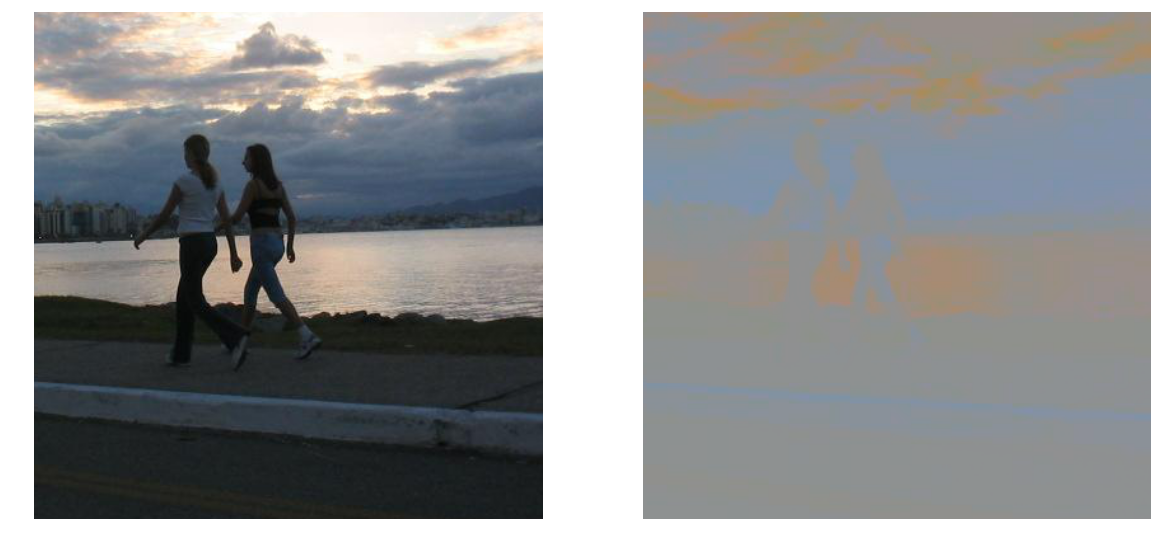

In [195]:
# Extract hue
from copy import deepcopy
sample = 0
sample_in_df = np.where(select)[0][sample]
print sample_in_df
print nat_df['trial'][sample_in_df]
print nat_df['fixation'][sample_in_df]
print nat_df['impath'][sample_in_df] + '/' + nat_df['imname'][sample_in_df]
im = deepcopy(X[sample,:,:,:])

im[0,:,:] += 103.939
im[1,:,:] += 116.779
im[2,:,:] += 123.68

im = np.transpose(im[::-1,:,:], [1, 2, 0])
#im = np.transpose(im, [1, 2, 0])
im.shape
hue = V4pyutils.get_hue_image(im)

# Visualize hue image
Gviz = V4pyutils.visualize_hue_image(im)

# Show images
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(np.uint8(im))
plt.axis('off')

plt.subplot(122)
plt.imshow(np.uint8(255.0*Gviz))
plt.axis('off')
plt.show()

imX = deepcopy(im)

In [196]:
def get_pixel_range(n_pixels, n_blocks, patch_RF):
    row_block = np.int(np.floor(np.float(patch_RF)/np.float(n_blocks)))
    col_block = patch_RF % n_blocks
    blocksize = np.int(np.floor(np.float(n_pixels) / np.float(n_blocks)))
    pixel_range_rows = row_block * blocksize + np.arange(blocksize, dtype=int)
    pixel_range_cols = col_block * blocksize + np.arange(blocksize, dtype=int)
    return pixel_range_rows, pixel_range_cols

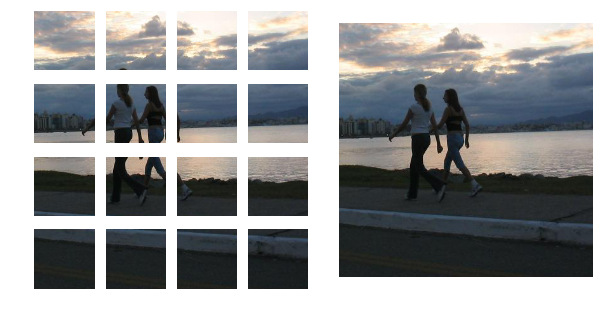

In [197]:
from copy import deepcopy
plt_idx = np.array([0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27])+1

plt.figure(figsize=(10,5))
### Extract only the block from within the neuron's RF
for patch_RF in range(16):

    pixel_range_rows, pixel_range_cols = get_pixel_range(400, 4, patch_RF)
    Xblock = deepcopy(X[:, :, 
                        pixel_range_rows[0]:(pixel_range_rows[-1]+1), 
                        pixel_range_cols[0]:(pixel_range_cols[-1]+1)])

    sample = 0
    sample_in_df = np.where(select)[0][sample]
    #print sample_in_df
    #print nat_df['impath'][sample_in_df] + '/' + nat_df['imname'][sample_in_df]
    im = deepcopy(Xblock[sample,:,:,:])

    im[0,:,:] += 103.939
    im[1,:,:] += 116.779
    im[2,:,:] += 123.68

    im = np.transpose(im[::-1,:,:], [1, 2, 0])
    im.shape
    hue = V4pyutils.get_hue_image(im)

    # Visualize hue image
    Gviz = V4pyutils.visualize_hue_image(im)

    # Show images
    
    plt.subplot(4,8,plt_idx[patch_RF])
    plt.imshow(np.uint8(im))
    plt.axis('off')

    #plt.subplot(122)
    #plt.imshow(np.uint8(255.0*Gviz))
    #plt.axis('off')
    #plt.show()

plt.subplot(1,2,2)
plt.imshow(np.uint8(imX))
plt.axis('off')
plt.show()

### Extract hue and plot against firing rate

In [279]:
from copy import deepcopy
from scipy.stats import circmean
plt_idx = np.array([0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27])+1

patch_RF = 14
hues = list()

pixel_range_rows, pixel_range_cols = get_pixel_range(400, 4, patch_RF)
Xblock = deepcopy(X[:, :, 
                    pixel_range_rows[0]:(pixel_range_rows[-1]+1), 
                    pixel_range_cols[0]:(pixel_range_cols[-1]+1)])

### Extract only the block from within the neuron's RF
for sample in tqdm(range(Xblock.shape[0])):

    

    # Copy the block into a separate var
    im = deepcopy(Xblock[sample,:,:,:])
    
    # Add back the mean
    im[0,:,:] += 103.939
    im[1,:,:] += 116.779
    im[2,:,:] += 123.68

    # Reshape to pixels x pixels x 3 and convert BGR to RGB
    im = np.transpose(im[::-1,:,:], [1, 2, 0])
    im.shape
    
    # Extract hue image
    hue = V4pyutils.get_hue_image(im)
    
    # Compute circ_mean
    hues.append(circmean(hue, high=np.pi, low=-np.pi))
    
hues = np.array(hues)

100%|██████████| 5555/5555 [00:05<00:00, 1043.30it/s]


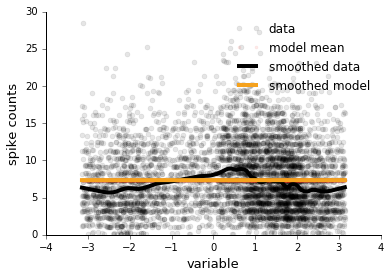

In [280]:
Models = dict()
Models['mean'] = dict()
Models['mean']['Yt_hat'] = np.mean(Y[sub_idx])*np.ones(np.size(Y[sub_idx]))
V4pyutils.plot_var_vs_counts(x_variable=hues[sub_idx], y_counts=Y[sub_idx], models_fit=Models, model='mean',lowess_frac=0.1)

In [212]:
select

array([False,  True, False, ..., False, False, False], dtype=bool)

In [215]:
nat_df['select']=select

In [237]:
sub_idx = nat_df['fix_duration'][select] < 1.0

In [238]:
sub_idx = sub_idx.values

In [240]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.layers.core import Lambda
from keras.models import model_from_json
import cv2, numpy as np

def poissoncrown(architecture_file=None, weights_file=None, n_pops=1, n_train = 1, verbose=0):
    
    model = Sequential()
    model = model_from_json(open(architecture_file).read())
    model.load_weights(weights_file)

    # Remove the last layer
    for i in range(n_pops):
        model.pop()
    
    # Prevent previous layers from updating
    for l in model.layers:
            l.trainable = False
    
    # Add an exponential layer
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='linear', init='normal'))
    model.add(Lambda(lambda x: np.exp(x)))

    model.compile(loss='poisson', optimizer='rmsprop')
    
    if verbose:
        for i, l in enumerate(model.get_weights()):
            print i, np.shape(l)
            
        
    return model

Using Theano backend.
Using gpu device 2: GeForce GTX TITAN X (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5005)


In [242]:
model = poissoncrown(architecture_file='vgg16_architecture.json', 
                     weights_file='vgg16_weights.h5',
                     n_pops=1,
                     verbose=1)

0 (64, 3, 3, 3)
1 (64,)
2 (64, 64, 3, 3)
3 (64,)
4 (128, 64, 3, 3)
5 (128,)
6 (128, 128, 3, 3)
7 (128,)
8 (256, 128, 3, 3)
9 (256,)
10 (256, 256, 3, 3)
11 (256,)
12 (256, 256, 3, 3)
13 (256,)
14 (512, 256, 3, 3)
15 (512,)
16 (512, 512, 3, 3)
17 (512,)
18 (512, 512, 3, 3)
19 (512,)
20 (512, 512, 3, 3)
21 (512,)
22 (512, 512, 3, 3)
23 (512,)
24 (512, 512, 3, 3)
25 (512,)
26 (25088, 4096)
27 (4096,)
28 (4096, 4096)
29 (4096,)
30 (4096, 100)
31 (100,)
32 (100, 1)
33 (1,)


In [243]:
def trasfer_learning(architecture_file=None, weights_file=None, n_pops=1, n_train = 1, verbose=0):
    
    model = Sequential()
    model = model_from_json(open(architecture_file).read())
    model.load_weights(weights_file)

    # Remove the last layer
    for i in range(n_pops):
        model.pop()
    
    # Prevent previous layers from updating
    for l in model.layers:
            l.trainable = False
    
    # Add an exponential layer
    #model.add(Dense(100, activation='relu'))
    #model.add(Dense(1, activation='linear', init='normal'))
    model.add(Lambda(lambda x: x))

    model.compile(loss='poisson', optimizer='rmsprop')
    
    if verbose:
        for i, l in enumerate(model.get_weights()):
            print i, np.shape(l)
            
        
    return model

In [244]:
model = trasfer_learning(architecture_file='vgg16_architecture.json', 
                     weights_file='vgg16_weights.h5',
                     n_pops=1,
                     verbose=1)

0 (64, 3, 3, 3)
1 (64,)
2 (64, 64, 3, 3)
3 (64,)
4 (128, 64, 3, 3)
5 (128,)
6 (128, 128, 3, 3)
7 (128,)
8 (256, 128, 3, 3)
9 (256,)
10 (256, 256, 3, 3)
11 (256,)
12 (256, 256, 3, 3)
13 (256,)
14 (512, 256, 3, 3)
15 (512,)
16 (512, 512, 3, 3)
17 (512,)
18 (512, 512, 3, 3)
19 (512,)
20 (512, 512, 3, 3)
21 (512,)
22 (512, 512, 3, 3)
23 (512,)
24 (512, 512, 3, 3)
25 (512,)
26 (25088, 4096)
27 (4096,)
28 (4096, 4096)
29 (4096,)


In [246]:
patch_RF = 14

pixel_range_rows, pixel_range_cols = get_pixel_range(400, 4, patch_RF)
Xblock = deepcopy(X[:, :, 
                    pixel_range_rows[0]:(pixel_range_rows[-1]+1), 
                    pixel_range_cols[0]:(pixel_range_cols[-1]+1)])

In [248]:
cv2.ock.shape

(5555, 3, 100, 100)

In [267]:
XB = list()
for i in range(np.shape(Xblock)[0]):
    im = np.squeeze(Xblock[i,:,:,:])
    im = np.transpose(im, [1,2,0])
    resized_image = cv2.resize(im, (224, 224))
    resized_image = np.transpose(resized_image, [2,0,1])
    XB.append(resized_image)

In [270]:
np.shape(np.array(XB))

(3, 224, 224)

In [271]:
X_transf = model.predict(np.array(XB), verbose=1)

5555/5555 [==============================] - 53s    


In [ ]:
import sys
sys.path.append('../')
import V4pyutils

In [272]:
Y_t, P_t = V4pyutils.fit_cv(X_transf, Y, verbose=2)

...runnning cv-fold 1 of 10
pR2:  0.115801052482
...runnning cv-fold 2 of 10
pR2:  0.120734038837
...runnning cv-fold 3 of 10
pR2:  0.0739932759591
...runnning cv-fold 4 of 10
pR2:  0.102729011084
...runnning cv-fold 5 of 10
pR2:  0.0981364842467
...runnning cv-fold 6 of 10
pR2:  0.101461909099
...runnning cv-fold 7 of 10
pR2:  0.0716556010025
...runnning cv-fold 8 of 10
pR2:  0.109208141083
...runnning cv-fold 9 of 10
pR2:  0.0995645771074
...runnning cv-fold 10 of 10
pR2:  0.0520286263477
pR2_cv: 0.094531 (+/- 0.006527)


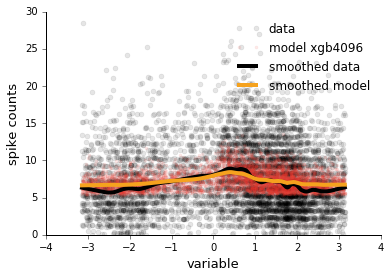

In [281]:
Models = dict()
Models['xgb4096'] = dict()
Models['xgb4096']['Yt_hat'] = Y_t
V4pyutils.plot_var_vs_counts(x_variable=hues, y_counts=Y, models_fit=Models, model='xgb4096', lowess_frac=0.1)